# Getting started
Kooplearn is a machine learning library designed with a specific purpose in mind: learn Koopman/Transfer operators of dynamical systems from data. For a user-friendly introduction to the operatorial perspective on dynamical systems check out [this blog post [TODO]](). 

In this article we will go through a typical training and inference pipeline in `kooplearn`, experimenting with the _noisy logistic map_, a one-dimensional dynamical system defined by the relation

$$
    x_{t + 1} = (4x_{t}(1 - x_{t}) + \xi_{t}) \mod 1.
$$

Here $\xi_{t}$ is just a noise term with density $\propto \cos^{N}(x)$, $N$ being an even integer. {footcite:t}`Kostic2022` reported a full characterization of the transfer operator of the noisy logistic map. In particular, the transfer operator has rank $N + 1$, it is _non-normal_, and its eigenvalues and eigenfunctions can be computed exactly. In `kooplearn` we provide an implementation of the noisy logistic map in {class}`kooplearn.datasets.LogisticMap`.

## Generating and splitting the data

In [20]:
from kooplearn.datasets import LogisticMap

# Defining the number of samples for each data split
train_samples = 50000 
test_samples = 1000

logmap = LogisticMap(N = 20, rng_seed = 0) # Setting the rng_seed for reproducibility

initial_condition = 0.5 # Setting the initial condition x_0 to start sampling the map

datasets = {
    'train': logmap.sample(initial_condition, train_samples),
    'test': logmap.sample(initial_condition, test_samples)
}

for split, ds in datasets.items():
    print(f"{split.capitalize()} split has shape {ds.shape}")

Train split has shape (50001, 1)
Test split has shape (1001, 1)


Okay, we have a numpy array of shape `(split_samples + 1, 1)` for each split, stored in the `datasets` dictionary. Notice that even if we requested `split_samples` the `sample` function returned one extra point. This is no accident, the "extra" point is actually the initial condition, and calling `logistic.sample` we have appended `split_samples` new fresh points to it.

## Learning the transfer operator on a dictionary of functions

The transfer operator $\mathcal{T}$ is a mathematical object that maps any function $f$ to its expected value after one step of the dynamics:

$$
(\mathcal{T}f)(x) := \mathbb{E}[f(X_t + 1) | X_t = x].
$$

A popular class of methods to learn $\mathcal{T}$ from data follows from the observation that the action of $\mathcal{T}$ on the span of a _finite_ number of functions $(\phi_{i})_{i = 1}^{d}$ is described by a $d\times d$ matrix, which can be learned from data via standard regression algorithms. If the chosen set of functions $(\phi_{i})_{i = 1}^{d}$ is rich enough, we should have a decent approximation of the transfer operator. We refer to {footcite:t}`Kostic2022` for a mathematically rigorous exposition of these topics. 

This strategy is implemented in the {class}`kooplearn.models.ExtendedDMD` model, which requires as input the functions $(\phi_{i})_{i = 1}^{d}$ specified as a feature map $x \mapsto  (\phi_{i}(x))_{i = 1}^{d}$. The choiche of feature map is highly problem dependent and `kooplearn` exposes an abstract base class {class}`kooplearn.abc.FeatureMap` as a blueprint to define arbitrary feature maps. For the noisy logistic map a sensible option is a set of orthogonal polynomials, such as the [Chebyshev polynomials of the first kind](https://en.wikipedia.org/wiki/Chebyshev_polynomials). Let's implement that by subclassing {class}`kooplearn.abc.FeatureMap`

In [21]:
import numpy as np
import scipy.special
from kooplearn.abc import FeatureMap

class ChebyshevPoly(FeatureMap):
    def __init__(self, max_order: int = 10):
        self.max_order = max_order # Will take polynomials up to order max_order (excluded)
    
    def __call__(self, data: np.ndarray):
        x = 2 * data - 1 # Transform the input data (defined on [0, 1]) to the interval [-1, 1] over which the Chebyshev polynomials are defined.
        phi = np.concatenate([scipy.special.eval_chebyt(n, x) for n in range(self.max_order)], axis=-1)
        return phi

Let's instantiate the feature map and test how it acts on one of our data splits.

In [22]:
feature_map = ChebyshevPoly(max_order = 4)

print(f"The first 5 training points are\n{datasets['train'][:5]}\nTheir feature map is\n{feature_map(datasets['train'][:5])}")

The first 5 training points are
[[0.5       ]
 [0.02461448]
 [0.05297965]
 [0.07993305]
 [0.14713471]]
Their feature map is
[[ 1.          0.         -1.         -0.        ]
 [ 1.         -0.95077105  0.80793118 -0.5855441 ]
 [ 1.         -0.89404071  0.59861757 -0.17633624]
 [ 1.         -0.84013391  0.41164997  0.14845172]
 [ 1.         -0.70573058 -0.00388869  0.71121932]]


```{footbibliography}
```

## Fitting the model
We have now everything we need to learn the transfer operator of the noisy logistic map:
1. A model: {class}`kooplearn.models.ExtendedDMD`
2. A feature map `ChebyshevPoly`
3. Some train/validation/test data in `datasets`
In order to fit the model we first need to instantiate it, similarly to how is done in [scikit-learn](https://scikit-learn.org/stable/index.html). {class}`kooplearn.models.ExtendedDMD` requires at least the feature map to be specified. In addition to the feature map, we will add a tiny bit of Tikhonov regularization to stabilize the model.

In [36]:
from kooplearn.models import ExtendedDMD

feature_map = ChebyshevPoly(max_order = 32) # We choose a max_order of 10, which is appropriate for this problem (See the DPNets paper by Kostic et al. for more details)
model = ExtendedDMD(feature_map, tikhonov_reg=1e-6)

As explained in [the documentation page of kooplearn's data paradigm](kooplearn_data_paradigm), `kooplearn` expects data organized into context windows. Broadly speaking, a context window is just a (usually short) sequence of consecutive observations of the system. A context window encloses the 'past' in its _lookback window_ and the 'future' in its _lookforward window_. Intuitively, everything in the lookback window is the information we need to provide, at inference time, to predict what will happen in the lookforward window. By using context windows we depart from the usual paradigm in supervised learning in which data is categorized into inputs and outputs. Rather, when studying dynamical systems we find it more natural to conceive a "data point" as a context window containing the dynamical information at a given point in time.

Kooplearn provides simple utility functions to create context windows out of trajectories, such as {meth}`kooplearn.data.traj_to_contexts`.

In [37]:
from kooplearn.data import traj_to_contexts

contexts = {k: traj_to_contexts(v) for k, v in datasets.items()} # Converting the trajectories to contexts
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {ds.shape[0]} contexts of length {ds.shape[1]} with {ds.shape[2]} features each")

Train contexts have shape (50000, 2, 1): 50000 contexts of length 2 with 1 features each
Test contexts have shape (1000, 2, 1): 1000 contexts of length 2 with 1 features each


By default {meth}`kooplearn.data.traj_to_contexts` will create contexts of lenght 2, as the minimal amount of frames to learn a dynamical relation is one for the lookback and one for the lookforward. Now, fitting the model we defined above is as easy as calling: 

In [38]:
model.fit(contexts['train'])

Fitted ExtendedDMD model. Lookback length set to 1


As logged above, the class {class}`kooplearn.models.ExtendedDMD` automatically inferred the length of the lookback window from the provided data. This behaviour is expected from every model, as described in {attr}`kooplearn.abc.BaseModel.lookback_len`.

## Evaluating the model
We conclude by evaluating the model on two different tasks
1. Predicting the next expected state by using `model.predict()`
2. Approximating the eigenvalues of the transfer operator via `model.eig()`

```{note}
Given the total absence of hyperparameter-tuning and/or model selection schemes, the numbers displayed below can be improved quite a bit.
```

In [39]:
from sklearn.metrics import mean_squared_error

def prediction_error(model, contexts):
    init_frames = contexts[:, :model.lookback_len, ...] # Everything in the lookback window is used for inference
    pred_frames = model.predict(init_frames) # Predicting the future frames
    true_frames = contexts[:, model.lookback_len:, ...].reshape(*pred_frames.shape) # The true frames are everything after the lookback length (i.e. the lookforward window)
    
    return mean_squared_error(true_frames, pred_frames)

for split, ds in contexts.items():
    print(f"Prediction error for {split.lower()}: {prediction_error(model, ds):.4f}")

Prediction error for train: 0.0569
Prediction error for test: 0.0507


The true and predicted eigenvalues of the noisy logistic map can be obtained using the `eig` method on `logmap` and `model`, respectively.

In [40]:
true_eigs = logmap.eig()
pred_eigs = model.eig()

NameError: name 'true_eigs' is not defined

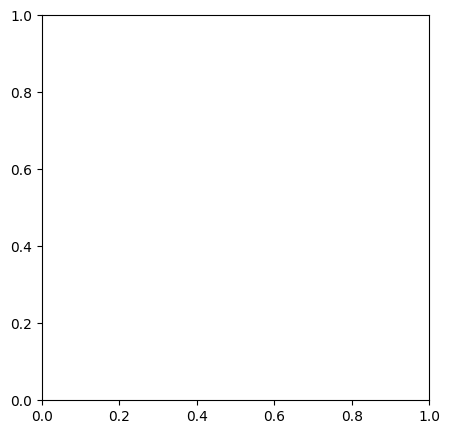

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(true_eigs.real, true_eigs.imag, label='True eigenvalues', marker='x', color='#9f1853')
ax.scatter(pred_eigs.real, pred_eigs.imag, label='Predicted eigenvalues', marker = '.', color='#0f62fe')
# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), linestyle='-', color='#999', lw=0.75)
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_title('Eigenvalues')
ax.legend()
plt.show()

As we can see, the model predicts very well the largest eigenvalue $\lambda_{1} = 1$, and fairly well a complex-conjugate pair of eigenvalues with real part $\approx - 0.25$. On the other hand, the cluster of eigenvalues around $0$ is predicted quite poorly. This is not surprising, however, as the noisy logsitcic map is known to be non-normal. Non-normality implies that the the eigenvalues of the matrix are extremely sensitive to perturbations, meaning that even a small error in estimating the Transfer operator (see the small prediction error above), does not guarantee a good estimation of the eigenvalues.